# Chronos-2 Foundation Model
In this notebook, we will show how to use Chronos-2 in Darts. If you are new to Darts, please check out the [Quickstart Guide](https://unit8co.github.io/darts/quickstart/00-quickstart.html) before proceeding.

Chronos-2 is a time series foundation model for zero-shot forecasting. That means that it can be used for forecasting **without any training or fine-tuning** since it has already been pre-trained on large-scale time series data. Chronos-2 supports multivariate time series forecasting with [covariates](https://unit8co.github.io/darts/userguide/covariates.html) (exogenous variables) and can produce probabilistic forecasts.

Check out the [Amazon Science Blog](https://www.amazon.science/blog/introducing-chronos-2-from-univariate-to-universal-forecasting) and the [original paper](https://arxiv.org/abs/2510.15821) for technical details.

<div class="alert alert-success" role="alert">
  Fine-tuning Chronos-2 on your own data is not yet supported in Darts, but may be added in the future.
</div>

In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import warnings

import numpy as np

from darts.datasets import ElectricityConsumptionZurichDataset
from darts.models import Chronos2Model

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

c:\Users\Kurokabe\miniconda3\envs\darts\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The StatsForecast module could not be imported. To enable support for the AutoARIMA, AutoETS and Croston models, please consider installing it.
The `XGBoost` module could not be imported. To enable XGBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `XGBoost` module could not be imported. To enable XGBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


## Data Preparation

Here, we will use the [Electricity Consumption Zurich Dataset](https://unit8co.github.io/darts/generated_api/darts.datasets.html#darts.datasets.ElectricityConsumptionZurichDataset), which records the electricity consumption of households & SMEs (`"Value_NE5"` column) and business & services (`"Value_NE7"`) in Zurich, Switzerland, along with weather covariates such as temperature (`"T [°C]"`) and humidity (`"Hr [%Hr]"`).
Values are recorded every 15 minutes between January 2015 and August 2022.

<details>

<summary><strong>Train-Test Split</strong></summary>

Even though Chronos-2 is pre-trained already, we still need to split the data into training and test sets. That is because `Chronos2Model` follows the Darts unified interface and will require calling the `fit()` method before forecasting. However, no training or fine-tuning will be performed during the `fit()` call.

</details>

<details>

<summary><strong>Data Scaling</strong></summary>

Unlike other deep learning models in Darts, Chronos-2 does not require data scaling since it has its own internal data normalization mechanism. Therefore, we will skip the scaling step in this notebook.

</details>

In [4]:
# convert to float32 as Chronos-2 works with float32 input
data = ElectricityConsumptionZurichDataset().load().astype(np.float32)
# extract households energy consumption
ts_energy = data["Value_NE5"]
# extract temperature, solar irradiation and rain duration
ts_weather = data[["T [°C]", "StrGlo [W/m2]", "RainDur [min]"]]
# split into train and validation sets by last 7 days
train_energy, val_energy = ts_energy.split_before(len(ts_energy) - 7 * 24 * 4)

Let's quickly visualize the last 7 days of the electricity consumption data.

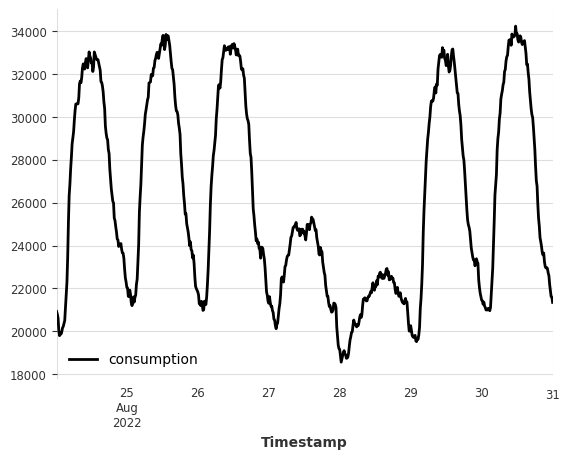

In [5]:
val_energy.plot(label="consumption");

In [ ]:
from peft import LoraConfig

In [7]:
peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q", "v"],  # optionally indicate target modules
)

In [9]:
# use last 30 days of data to predict next 7 days
model = Chronos2Model(
    input_chunk_length=30 * 24 * 4,
    output_chunk_length=7 * 24 * 4,
    peft_config=peft_config,
    pl_trainer_kwargs={"accelerator": "gpu"},
)

In [10]:
model.fit(
    series=train_energy,
    verbose=True,
)

trainable params: 589,824 || all params: 120,067,488 || trainable%: 0.4912


MisconfigurationException: No supported gpu backend found!